# Collaboration and Competition

---

Project 3 from the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

Importing the necessary packages, should be done only once.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
!pip -q install ./python

In [2]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
use_graphics = False
use_parallel = False
file_name = '..\Tennis_Windows_x86_64\Tennis.exe'
checkpoint_name = 'checkpoint'

In [4]:
env = UnityEnvironment(file_name=file_name, no_graphics=(not use_graphics))

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## Definitions

In [7]:
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Actor + Critic



In [9]:
BUFFER_SIZE = int(1e6)#int(1e5)  # replay buffer size
BATCH_SIZE = 256#128#64#128#256        # minibatch size
GAMMA = 0.99#0.999            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4#1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3#1e-4#3e-4        # learning rate of the critic
WEIGHT_DECAY = 1e-6#1e-4#0   # L2 weight decay
SIGMA = 0.15#0.1#0.85#0.05#0.1#0.2
NOISE_DECAY = 0.9999

fc1_units = 200#256#400
fc2_units = 150#128#300

In [10]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

In [11]:
class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.leaky_relu(self.fc1(state))
        x = F.leaky_relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear((state_size+action_size)*num_agents, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = torch.cat((state, action), dim=1)
        x = F.leaky_relu(self.fcs1(xs))
        x = F.leaky_relu(self.fc2(x))
        return self.fc3(x)

## Training

### Agent

In [12]:
class Agent():
    def __init__(self, state_size, action_size, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        
        self.learn_counter = 0
        
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        
        self.noise = OUNoise(action_size, random_seed)
        self.noise_decay = NOISE_DECAY

        
    def step(self):
        if len(memory) > BATCH_SIZE:
            experiences = memory.sample()
            self.learn(experiences, GAMMA)
            
    def act(self, state, add_noise = True):
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()

        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        self.learn_counter += 1
        states_l, actions_l, rewards, next_states_l, dones = experiences
        
        try:
            states_t = torch.cat(states_l, dim=1).to(device)
        except Exception as e:
            print(e,type(states_l),states_l)
        actions_t = torch.cat(actions_l, dim=1).to(device)
        next_states_t = torch.cat(next_states_l, dim=1).to(device)
        
        next_actions_l = [self.actor_target(next_state) for next_state in next_states_l]
        next_actions_t = torch.cat(next_actions_l, dim=1).to(device)
        
        target_Q = self.critic_target.forward(next_states_t, next_actions_t)
        Q_targets = rewards + (gamma * target_Q * (1-dones))
        
        currentQ = self.critic_local.forward(states_t, actions_t)
        
        critic_loss = F.mse_loss(currentQ, Q_targets)  
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()
        
        actions_pred_l = [self.actor_local(state) for state in states_l]
        actions_pred_t = torch.cat(actions_pred_l, dim=1).to(device)

        actor_loss = -self.critic_local(states_t, actions_pred_t).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), 0.5)
        self.actor_optimizer.step()

        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)
        
    def soft_update(self, local_model, target_model, tau):
        for local_param, target_param in zip(local_model.parameters(), target_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
    

In [13]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

In [14]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = [torch.from_numpy(np.vstack([e.state[idx] for e in experiences if e is not None])).float().to(device) for idx in range(num_agents)]
        actions = [torch.from_numpy(np.vstack([e.action[idx] for e in experiences if e is not None])).float().to(device) for idx in range(num_agents)]
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = [torch.from_numpy(np.vstack([e.next_state[idx] for e in experiences if e is not None])).float().to(device) for idx in range(num_agents)]
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Multi-Agent DDPG

Train the Agent with DDPG for multi-agent.

In [15]:
n_episodes = 4000
max_t = 800
seed = random.random()
min_score = 0.5

In [16]:
memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

In [17]:
def save_movel(agents, name='checkpoint'):
    for i in range(num_agents):
        torch.save(agents.ddpg_agents[i].actor_local.state_dict(), '{}_actor{}.pth'.format(name, i))
        torch.save(agents.ddpg_agents[i].critic_local.state_dict(), '{}_critic{}.pth'.format(name, i))

def load_model(agents, name='checkpoint'):
    for i in range(num_agents):
        agents.ddpg_agents[i].actor_local.load_state_dict(torch.load('{}_actor{}.pth'.format(name, i)))
        agents.ddpg_agents[i].critic_local.load_state_dict(torch.load('{}_critic{}.pth'.format(name, i)))

In [18]:
class MDDPGAgent:

    def __init__(self, random_seed):
        self.ddpg_agents = [Agent(state_size,action_size,random_seed) for _ in range(num_agents)]

    def step(self, states, actions, rewards, next_states, dones):
        memory.add(states, actions, rewards, next_states, dones)

        for agent in self.ddpg_agents:
            agent.step()

    def act(self, states, add_noise=True):
        actions = np.zeros([num_agents, action_size])
        for index, agent in enumerate(self.ddpg_agents):
            actions[index, :] = agent.act(states[index], add_noise)
        return actions

    def reset(self):        
        for agent in self.ddpg_agents:
            agent.reset()

In [19]:
scores_max_hist = []
scores_mean_hist = []
agent = MDDPGAgent(seed)

In [20]:
def train(n_episodes=2000, max_t=700):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        score = np.zeros(num_agents)
        step = 0
        for t in range(max_t):
            step += 1
            actions = agent.act(states, add_noise=False)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            score += rewards
            agent.step(states, actions, rewards, next_states, dones)
            if np.any(dones):
                break 
            states = next_states
        score_max = np.max(score)
        scores_deque.append(score)
        scores.append(score)
        current_mean_scores = np.mean(scores_deque)
        scores_max_hist.append(score_max)
        scores_mean_hist.append(current_mean_scores)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, current_mean_scores, np.mean(score)), end="")
        if i_episode % 100 == 0:
            save_movel(agent, checkpoint_name)
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, current_mean_scores))
        if current_mean_scores >= min_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, current_mean_scores))
            save_movel(agent, checkpoint_name)
            break
    return scores


In [21]:
print('Training started using {} episodes and {} steps'.format(n_episodes, max_t))
scores = train(n_episodes=n_episodes, max_t=max_t)

Training started using 4000 episodes and 800 steps
Episode 100	Average Score: -0.00	Score: -0.00
Episode 200	Average Score: -0.00	Score: -0.00
Episode 300	Average Score: 0.01	Score: -0.000
Episode 400	Average Score: 0.01	Score: -0.00
Episode 500	Average Score: 0.02	Score: 0.050
Episode 600	Average Score: 0.01	Score: 0.050
Episode 700	Average Score: 0.00	Score: -0.00
Episode 800	Average Score: 0.02	Score: 0.050
Episode 900	Average Score: 0.04	Score: 0.050
Episode 1000	Average Score: 0.09	Score: 0.05
Episode 1100	Average Score: 0.06	Score: 0.100
Episode 1200	Average Score: 0.11	Score: 0.20
Episode 1300	Average Score: 0.19	Score: 0.40
Episode 1375	Average Score: 0.50	Score: 2.10
Environment solved in 1375 episodes!	Average Score: 0.50


In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

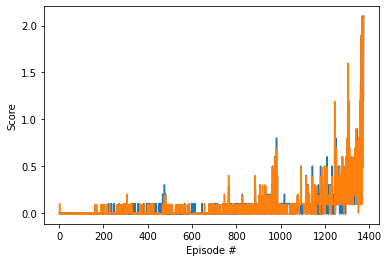

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Test

In [24]:
n_episodes = 3
load_model(agent, checkpoint_name)

In [25]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment

In [26]:
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
total_score = 0
for i_episode in range(1, n_episodes+1):
    score = np.zeros(num_agents)
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations
    while True:
        action = agent.act(state)
        env_s = env.step(action)
        env_info = env_s[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        score += rewards
        state = next_states
        if np.any(dones):
            break
    print(f"\rEpisode {i_episode} \tScore: {score}")
    total_score += score
print(f"\rAverage score in {n_episodes} episodes: {total_score/n_episodes}")

Episode 1 	Score: [0.39000001 0.50000001]
Episode 2 	Score: [0.49000001 0.50000001]
Episode 3 	Score: [0.80000001 0.69000001]
Average score in 3 episodes: [0.56000001 0.56333334]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [27]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

In [28]:
env.close()